# An introduction to Power Calculations for GWAS Traits

### What is Statistical Power?

When we are doing genetic studies we're often asking the question: "Does carrying this genetic variant impact your level of trait X". This means that for each variant, we have to conduct a statistical test, where there are four different potential outcomes (assuming we actually know the truth - which in the real world we do not!): 


  Test/Truth   | True  | False |
------| ------------- | ------------- |
True  | Correct Rejection  | False-Positive  |
False | False-Negative  | Correct Anti-Rejection  |


What we typically want to do is make sure that we are maximizing the ratio of `Correct Rejection / (Correct-Rejection + False-Negatives)`, also known as "statistical power". Thought another way, if we have 90% power for detecting an effect that we know truly comes from a non-zero effect then we can feel quite confident about those that are rejected!

For a clearer and broader summary of statistical power in GWAS, please see this tutorial: https://www.mv.helsinki.fi/home/mjxpirin/GWAS_course/material/GWAS3.html

We also note here that GWAS are designed to be performed with [high-throughput genotyping data](https://www.illumina.com/techniques/popular-applications/genotyping.html) primarily and this is the kind of experimental design that we will be taking advantage of. While GWAS can be performed using whole-genome data, it is much more costly but can be more informative for disease architectures that rely primarily on very rare variants. 


### Key parameters of interest

* **"Sample-Size" ($N$)**: How many individuals we have sampled **and** have phenotypic measurements for.
* **"Effect-Size" ($\beta$)**: How large the underlying causal effect is, in units of standard deviations typically (e.g. 1 standard deviation in BMI is approximately ~8 pts, which is a sizeable difference!)
* "Minor Allele Frequency" (MAF): How rare is the allele that is causing the intended effect? (e.g. a MAF of 1% means 1/50 people will carry the allele)
* "Imputation $R^2$" or "Tagging $R^2$ " (r2): This is a statement of how correlated the underlying variant is to the actual *true* causal variant. In most cases this will be quite high (r2 > 0.9), but for rare variants this can be quite low and should be taken into account when evaluating power.
* "Proportion of Cases": The proportion of cases in a dataset for a binary trait (e.g. 10% of the individuals in the dataset have diabetes, so they are cases).

### Key Questions you will be able to address in this notebook

* Estimate the sample-size required to detect an allele at a specific frequency and effect-size threshold with a specific amount of power.
* Estimate the $\beta$ - MAF relationship for a specified sample-size and power-threshold.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import sys
sys.path.append('../qtl_power/')
from gwas import GwasQuant, GwasBinary

%matplotlib inline

## Evaluating Power for Quantitative Traits under Simple Linear Regression

### Effect-Size vs Power as a function of Sample-Size

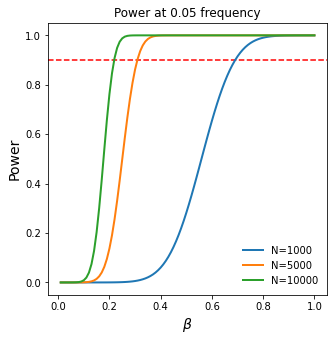

In [2]:
# NOTE: this is for an example like LDL-cholesterol levels 
ns = [1000, 5000, 10000] # Sample-Sizes to evaluate
min_beta = 0.01 # Minimum Effect-Size
max_beta = 1.0 # Maximum Effect-Size
maf = 0.05 # Target Minor-Allele Frequency
r2 = 1 # Minimum r2 from imputation
target_power = 0.90 # Target Power
alpha = 5e-8 #The p-value threshold for a GWAS (typically)

# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
# Setting up the figure 
betas = np.linspace(min_beta, max_beta, 100)
gwas_power = GwasQuant()
fig, ax = plt.subplots(1,1,figsize=(5,5))

# Draw the line for the target amount of power
# NOTE: the point at which they intersect the line is the effect-size that is detectable (it should shift leftward as N increases!)
ax.axhline(y=target_power, linestyle='--', color='red')

# For each sample-size, draw the curve for power to detect as a function of effect-size.
for n in ns:
    powers = [gwas_power.quant_trait_power(n=n, beta=b, r2=r2, p=maf, alpha=alpha) for b in betas]
    ax.plot(betas, powers, lw=2, label=f'N={n}')

# Setup the axis labels ... 
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel('Power', fontsize=14)
ax.set_title(f'Power at {maf} frequency')
ax.legend(frameon=False)

### MAF vs. Effect-Size as a function of Sample-Size 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.69it/s]


Text(0.5, 0, 'MAF')

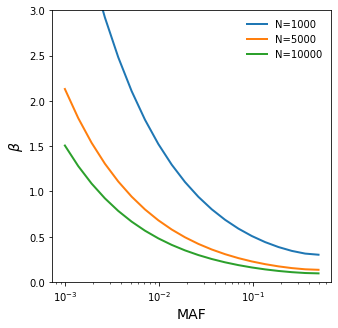

In [3]:
ns = [1000, 5000, 10000] # Sample-Sizes
min_maf = 0.001
max_maf = 0.5
r2=1.0
target_power = 0.9
alpha = 5e-8

# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
fig, ax = plt.subplots(1,1,figsize=(5,5))
gwas_power = GwasQuant()
# Setup the grid of minor-allele frequencies
ps = np.logspace(np.log10(min_maf), np.log10(max_maf), 20) # 20 points offers decent speed ...

# For each sample-size, find the MAF-beta curve that meets this power demand
# NOTE: lower is always better in this case!
for n in tqdm(ns):
    opt_betas = [gwas_power.quant_trait_beta_power(n=n, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]
    ax.plot(ps, opt_betas, lw=2, label=f'N={n}')

ax.set_xscale('log') # scaling the x-axis by the log of the frequency 
ax.set_ylim(0, 3) # limiting the y-axis
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)

## Evaluating Power for Case/Control Traits 

### Effect-Size vs. Power as a function of Sample-Size

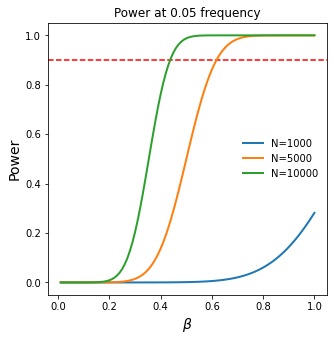

In [4]:
# NOTE: this is for an example like cases of sickle-cell anemia for example ... 
ns = [1000, 5000, 10000] # Sample-Sizes to evaluate
min_beta = 0.01 # Minimum Effect-Size
max_beta = 1.0 # Maximum Effect-Size
maf = 0.05 # Target Minor-Allele Frequency
r2 = 1 # Minimum r2 from imputation
target_power = 0.90 # Target Power
alpha = 5e-8 #The p-value threshold for a GWAS (typically)
prop_cases = 0.5 # the proportion of cases in the dataset (0.5 is the best!)


# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
# Setting up the figure 
betas = np.linspace(min_beta, max_beta, 100)
gwas_power = GwasBinary()
fig, ax = plt.subplots(1,1,figsize=(5,5))

# Draw the line for the target amount of power
# NOTE: the point at which they intersect the line is the effect-size that is detectable (it should shift leftward as N increases!)
ax.axhline(y=target_power, linestyle='--', color='red')

# For each sample-size, draw the curve for power to detect as a function of effect-size.
for n in ns:
    powers = [gwas_power.binary_trait_power(n=n, beta=b, r2=r2, p=maf, alpha=alpha, prop_cases=prop_cases) for b in betas]
    ax.plot(betas, powers, lw=2, label=f'N={n}')

# Setup the axis labels ... 
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel('Power', fontsize=14)
ax.set_title(f'Power at {maf} frequency')
ax.legend(frameon=False)

### MAF vs. Effect-Size as a function of Sample-Size (for a specified Power)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.18it/s]


Text(0.5, 0, 'MAF')

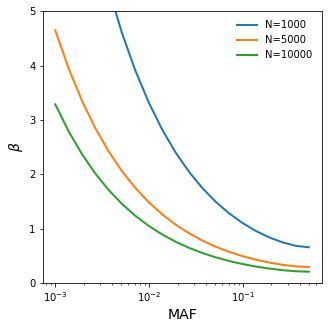

In [5]:
ns = [1000, 5000, 10000] # Sample-Sizes
min_maf = 0.001
max_maf = 0.5
r2=1.0
target_power = 0.9
alpha = 5e-8
prop_cases = 0.3 # Proportion of cases: the closer to 0.5 that this gets, the better ... 

# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ps = np.logspace(np.log10(min_maf), np.log10(max_maf), 20)
gwas_power = GwasBinary()
for n in tqdm(ns):
    opt_betas = [gwas_power.binary_trait_beta_power(n=n, p=p, power=target_power, prop_cases=prop_cases) for p in ps]
    ax.plot(ps, opt_betas, lw=2, label=f'N={n}')

ax.set_xscale('log')
ax.set_ylim(0, 5)
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)

### The impact of the proportion of cases on power to detect variants at different frequencies

If we hold the sample-size constant, a case:control ratio close to 1:1 has a substantially higher power than a design where these are unbalanced. In the following example, you can see how both sample-size and the proportion of cases interact to create equivalently powered designs. There is a rule to try to make the cases:control ratio as balanced as possible, but not at the cost of obtaining many more samples. For example,  we see that the power threshold is effectively the same between collecting (1200 cases and 2000 cases, but with 6000 samples vs. 4000 samples), which can really be important if collecting cases is much more expensive than collecting controls!

3it [00:01,  2.23it/s]


Text(0.5, 0, 'MAF')

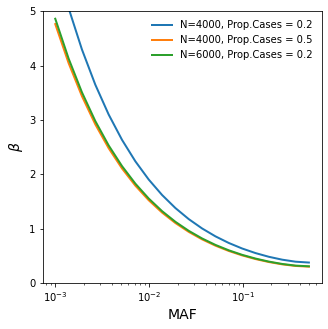

In [6]:

ns = [4000, 4000, 6000] # Sample-Size (feel free to change this!)
prop_cases = [0.2, 0.5, 0.2] # Proportion of cases: the closer to 0.5 that this gets, the better ... 

min_maf = 0.001 # minimal MAF
max_maf = 0.5 # maximal MAF
r2=0.90
target_power = 0.9
alpha = 5e-8

# The length of sample-sizes and proportion of cases must be the same!
assert len(ns) == len(prop_cases)

# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ps = np.logspace(np.log10(min_maf), np.log10(max_maf), 20)
gwas_power = GwasBinary()
for x,n in tqdm(zip(prop_cases, ns)):
    opt_betas = [gwas_power.binary_trait_beta_power(n=n, p=p, power=target_power, prop_cases=x) for p in ps]
    ax.plot(ps, opt_betas, lw=2, label=f'N={n}, Prop.Cases = {x}')

ax.set_xscale('log')
ax.set_ylim(0, 5)
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)

## Real-Data Example: HDL Cholesterol from the Pan-UKBB

As an example from real public data, lets explore some of the most significant associations from the [Pan-UKBB](https://pan.ukbb.broadinstitute.org/), which looks at association statistics between multiple ancestry groups defined in the [UK Biobank](https://www.ukbiobank.ac.uk/). We should note that there are *many many* more European-ancestry individuals in the UK Biobank when compared to African-ancestry individuals. By running the two cells below, we can see that the power predictions actually are pretty good for real data and can motivate lots of predictions on what we might find at larger sample-sizes!

In [7]:
import pandas as pd

# Read in the AFR-ancestry Associations for HDL-Cholesterol
afr_top_signals = pd.read_csv('../qtl_power/data/panukbb_30760.hdl_cholesterol.afr_filt.tsv.gz', sep="\t")

# Read in the EUR-ancestry Associations for HDL-Cholesterol
eur_top_signals = pd.read_csv('../qtl_power/data/panukbb_30760.hdl_cholesterol.eur_filt.tsv.gz', sep="\t")
afr_top_signals.head()

,chr,pos,af_AFR,beta_AFR,se_AFR,pval_AFR
0,11,116706343,0.5146,0.11800,0.01737,-25.22
1,11,116733316,0.4055,0.09777,0.01743,-17.72
2,15,58683366,0.4477,-0.09939,0.01676,-19.61
3,16,56994894,0.4266,0.22710,0.01691,-92.99
4,19,11333596,0.2100,-0.12970,0.02099,-21.16


Text(0.5, 1.0, 'Pan-UKBB HDL Cholesterol\n(Phecode 30760)')

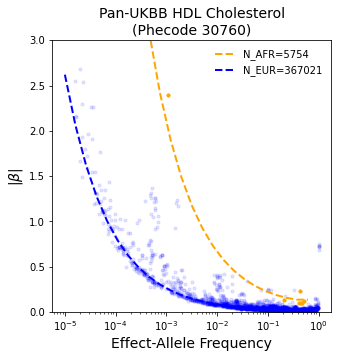

In [8]:

# NOTE: these are the actual sample-sizes for each of the ancestry groups! 
N_afr, N_eur = 5754, 367021


# NOTE: feel free to change any of these three parameters for exploration! 
r2=0.90
target_power = 0.90
alpha = 5e-8


# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
gwas_power = GwasQuant()
ps = np.logspace(np.log10(1e-5), np.log10(1.0), 25)
# For each sample-size, find the MAF-beta curve that meets this power demand
opt_betas_afr = [gwas_power.quant_trait_beta_power(n=N_afr, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]
opt_betas_eur = [gwas_power.quant_trait_beta_power(n=N_eur, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]

fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
ax.plot(ps, opt_betas_afr, lw=2, label=f'N_AFR={N_afr}', linestyle='--', color='orange')
ax.plot(ps, opt_betas_eur, lw=2, label=f'N_EUR={N_eur}', linestyle='--', color='blue')
ax.scatter(afr_top_signals.af_AFR.values, np.abs(afr_top_signals.beta_AFR.values), color='orange', s=10)
ax.scatter(eur_top_signals.af_EUR.values, np.abs(eur_top_signals.beta_EUR), alpha=0.1, zorder=-10, color='blue', s=10)
ax.set_xscale('log')

ax.legend(frameon=False)
ax.set_ylim(0,3)
ax.set_xlabel('Effect-Allele Frequency', fontsize=14)
ax.set_ylabel(r'$|\beta|$', fontsize=14)
ax.set_title('Pan-UKBB HDL Cholesterol\n(Phecode 30760)', fontsize=14)